In some mice, the electrical stimulation evoked responses appear to have a strong in-phase ~60 Hz oscillation, even after averaging across many trials. This notebook investigates that issue in different ways.

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import fftpack, integrate, signal, stats
import random

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

### Functions

In [5]:
# get event triggered firing rates USING find_nearest_ind
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate)
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

In [6]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

In [7]:
def bandpass_filt_design(len_signal, sample_rate, freq_limits=[1, 200], trans_width=0.2, order_multiple=4, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / freq_limits[0]) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [0,0,1,1,0,0]
    frex = [0, freq_limits[0]*(1-trans_width), freq_limits[0], freq_limits[1], freq_limits[1]*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, freq_limits[1]*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

In [8]:
def apply_notch_60Hz(data, sample_rate):
    '''
    Applies a notch filter to remove 60 Hz line noise.
    
    Inputs:
    -------
    data -- nd.array, (samples, channels)
    sample_rate -- int, Hz
    
    Outputs:
    --------
    filtered_data -- nd.array, (samples, channels)
    '''
    notch_freq = 60

    # initialize filtered signal
    filtered_data = data

    # create filter kernel using firwin
    frange = [notch_freq-0.75, notch_freq+0.75]
    order  = int(100*(sample_rate/frange[0]))
    order  = order + ~order%2

    # filter kernel
    filtkern = signal.firwin(order, frange, pass_zero=True, fs=sample_rate)

    # recursively apply to data
    filtered_data = signal.filtfilt(filtkern, 1, filtered_data, axis=0)
    
    return filtered_data

In [9]:
### still need to test ###
def get_good_channels(exp_inst):
    TEST_SWEEP = 0
    HI_NOISE_THRESH = 100.0 # default = 50.0 from Npx pipeline analysis
    LO_NOISE_THRESH = 3.0 # default = 3.0 from Npx pipeline analysis
    EARLY_RESPONSE_WINDOW = [0.001, 0.1] # looking in window from 1 to 100 ms for high absolute voltage
    VOLTAGE_THRESH = 1000 # uV
    TRIAL_FRACTION_THRESH = 0.1 # if more than 10% of trials exceed the VOLTAGE_THRESH, it is considered a bad ch

    if exp_inst.experiment_type == 'spontaneous':
        print('This experiment has no stimuli.')
        return
    
    ## Load eeg data and stim log ##
    expstimlog = pd.read_csv(exp_inst.stimulus_log_file)
    eegdata, eegts = exp_inst.load_eegdata()
    ## Cycle through all stim in TEST_SWEEP to get traces ##
    bad_channel_list = []
    sweep_stimlog = expstimlog[expstimlog['sweep']==TEST_SWEEP]
    for st_type in np.sort(sweep_stimlog.stim_type.unique()):
        param_list = np.sort(sweep_stimlog[sweep_stimlog['stim_type']==st_type].parameter.unique())
        for parami in param_list:
            ## Get event times and traces ##
            events = get_stim_events(sweep_stimlog, st_type, parami, TEST_SWEEP, remove_bad_epochs=False)
            event_traces, event_ts = get_evoked_traces(
                    eegdata,
                    eegts,
                    events,
                    1.0,
                    1.0,
                    exp_inst.ephys_params['EEG']['sample_rate']
                )
            ## RMS of baseline signal ##
            baseline_inds = event_ts < -0.005 # 5 ms before stim delivery
            baseline_rms = np.power(np.mean(np.power(event_traces[baseline_inds, :, :].astype('float32'), 2), 0), 0.5)
            bad_channel_list.append(np.squeeze(np.argwhere(
                (np.median(baseline_rms, 1) < LO_NOISE_THRESH) |
                (np.median(baseline_rms, 1) > HI_NOISE_THRESH)
            )))
            ## Max voltage in early response window ##
            early_inds = np.squeeze(np.argwhere((event_ts > EARLY_RESPONSE_WINDOW[0]) & (event_ts < EARLY_RESPONSE_WINDOW[1])))
            early_max_voltage = np.max(np.abs(event_traces[early_inds, :, :]), axis=0)
            bad_channel_list.append(np.squeeze(np.argwhere(
                np.mean(early_max_voltage > VOLTAGE_THRESH, axis=1) > TRIAL_FRACTION_THRESH
            )))
            
    bad_channels = np.unique(np.hstack(bad_channel_list))
    good_channels = np.array([x for x in range(eegdata.shape[1]) if x not in bad_channels])
    
    del expstimlog        
    del eegdata
    del eegts
    
    return good_channels, bad_channels

## Compare estim and visual evoked responses

Do mice that have pronounced 60 Hz in estim response also show it in the visual evoked response?

#### Subjects

In [9]:
subjects = {
    '521885': {
        'fullscreen': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\audio_vis1_2020-07-08_12-37-58\recording1',
        'biphasic': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\recording1',
    },
    '521886': {
        'fullscreen': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\audio_vis1_2020-07-15_13-28-29\recording1',
        'biphasic': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\recording1',
    },
    '543394': {
        'fullscreen': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\audio_vis1_2020-08-26_11-47-55\experiment1\recording1',
        'biphasic': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
    },
    '543395': {
        'fullscreen': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\audio_vis1_2020-09-02_13-25-18\experiment1\recording1',
        'biphasic': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\estim1_2020-09-03_13-19-42\experiment1\recording1',
    },
    '543396': {
        'fullscreen': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
        'biphasic': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
    },
#     '546657': {
#         'fullscreen': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546657\vis2_2020-09-24_16-15-06\experiment1\recording1',
#         'biphasic': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546657\stim_test_2020-10-16_11-46-11\experiment1\recording1',
#     },
    '546655': {
        'fullscreen': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
        'biphasic': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
    },
    '547868': {
        'fullscreen': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse547868\estim_vis_2020-12-04_11-24-26\experiment1\recording1',
        'biphasic': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse547868\estim_vis_2020-12-04_11-24-26\experiment1\recording1',
    },
}

In [10]:
state_sweeps = {
    '521885': {'fullscreen': [0, 1], 'biphasic': [0, 1]},
    '521886': {'fullscreen': [0, 1], 'biphasic': [0, 1]},
    '543394': {'fullscreen': [0, 3], 'biphasic': [0, 3]}, # both actually are [0,1,2]
    '543395': {'fullscreen': [0, 3], 'biphasic': [0, 3]}, # both actually are [0,1,2]
    '543396': {'fullscreen': [0, 1], 'biphasic': [0, 1]},
#     '546657': {'fullscreen': [0], 'biphasic': [0]},
    '546655': {'fullscreen': [0, 1], 'biphasic': [0, 1]},
    '547868': {'fullscreen': [0, 1], 'biphasic': [0, 1]},
}

In [11]:
stim_amps = {
    '521885': 50, # has [20, 50, 80]
    '521886': 50, # has [20, 50, 80]
    '543394': 50,
    '543395': 60,
    '543396': '80',
#     '546657': 50, # has [20, 30, 40, 50, 60, 70, 80, 90]
    '546655': '70', # has ['50', '70', '90']
    '547868': '40', # has ['20', '40', '60']
}

#### Start loading and collecting data

In [12]:
sub_exp = {}
sub_chs = {}
for mousei, experiments in subjects.items():
    print(mousei)
    sub_exp[mousei] = {}
    sub_chs[mousei] = {}
    for stim_type, recdiri in experiments.items():
        sub_exp[mousei][stim_type] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)
        sub_chs[mousei][stim_type] = get_good_channels(sub_exp[mousei][stim_type])
        print('{:s} bad chs: '.format(stim_type) + '[%s]' % ', '.join(map(str, sub_chs[mousei][stim_type][1])))

521885
Experiment type: sensory stimulation
SomnoSuite log file not found.
fullscreen bad chs: [6]
Experiment type: electrical stimulation
SomnoSuite log file not found.
biphasic bad chs: [6, 11, 12, 13, 14, 17]
521886
Experiment type: sensory stimulation
SomnoSuite log file not found.
fullscreen bad chs: [29]
Experiment type: electrical stimulation
SomnoSuite log file not found.
biphasic bad chs: [10, 11, 12, 13, 14, 15, 16, 17, 18]
543394
Experiment type: sensory stimulation
SomnoSuite log file not found.
fullscreen bad chs: []
Experiment type: electrical stimulation
SomnoSuite log file not found.
biphasic bad chs: [11, 12, 13, 14, 18, 19, 20]
543395
Experiment type: sensory stimulation
SomnoSuite log file not found.
fullscreen bad chs: []
Experiment type: electrical stimulation
SomnoSuite log file not found.
biphasic bad chs: [13]
543396
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
fullscreen bad chs: [4, 5, 7, 8, 10, 11, 29]
Experiment type: el

#### Get traces

In [13]:
## parameters ##
plot_before = 1. # s, look at 1 s pre-stim
plot_after = 1. # s, look at 1 s post-stim
apply_blsub = True
apply_filter_type = 'BW' # choose 'BW' (Butterworth) or 'FIR'

In [14]:
# sub_traces = {}
# sub_avg_traces = {}
# sub_traces_filter = {}
sub_avg_traces_filter = {}
for mousei, expdict in sub_exp.items():
#     sub_traces[mousei] = {}
#     sub_avg_traces[mousei] = {}
#     sub_traces_filter[mousei] = {}
    sub_avg_traces_filter[mousei] = {}
    for stim_type, expi in expdict.items():
        print(expi.mouse)
        # load stim log
        stim_log = pd.read_csv(expi.stimulus_log_file)

        # load data
        datai, tsi = expi.load_eegdata()
        eegchs = np.arange(datai.shape[1])
        
#         sub_traces[mousei][stim_type] = {}
#         sub_avg_traces[mousei][stim_type] = {}
#         sub_traces_filter[mousei][stim_type] = {}
        sub_avg_traces_filter[mousei][stim_type] = {}
        for sweepi in state_sweeps[mousei][stim_type]:
            # get evoked traces
            if stim_type == 'biphasic':
                parami = stim_amps[mousei]
            elif stim_type == 'fullscreen':
                parami = 'white'
            events = get_stim_events(stim_log, stim_type, parami, sweepi)
            event_traces, event_ts = get_evoked_traces(
                datai,
                tsi,
                events,
                plot_before,
                plot_after,
                expi.ephys_params['EEG']['sample_rate']
            )

            # design lowpass filter
            if apply_filter_type == 'FIR':
                filtb = lowpass_filt_design(
                    len(event_ts),
                    expi.ephys_params['EEG']['sample_rate'],
                    cutoff_freq=100, # original = 100
                    trans_width=0.2, # original = 0.2
                    order_multiple=11, # original = 11
                    plot_kern=False
                )
                filta = 1
            elif apply_filter_type == 'BW':
                filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')

            # apply filter
            if apply_blsub:
                blinds = np.squeeze(np.argwhere((event_ts > -0.2) & (event_ts < -0.005)))
                filtered_traces = signal.filtfilt(filtb, filta, event_traces - np.mean(event_traces[blinds,:,:], axis=0), axis=0)
            else:
                filtered_traces = signal.filtfilt(filtb, filta, event_traces, axis=0)

    #         sub_traces[mousei][stim_type] = [event_ts, event_traces]
    #         sub_avg_traces[mousei][stim_type] = [event_ts, np.mean(event_traces, axis=2)]
    #         sub_traces_filter[mousei][stim_type] = [event_ts, filtered_traces]
            sub_avg_traces_filter[mousei][stim_type][sweepi] = [event_ts, np.mean(filtered_traces, axis=2)]

        del datai
        del tsi

521885
521885
521886
521886
543394
543394
543395
543395
543396
543396
546655
546655
547868
547868


#### Plot them

<IPython.core.display.Javascript object>


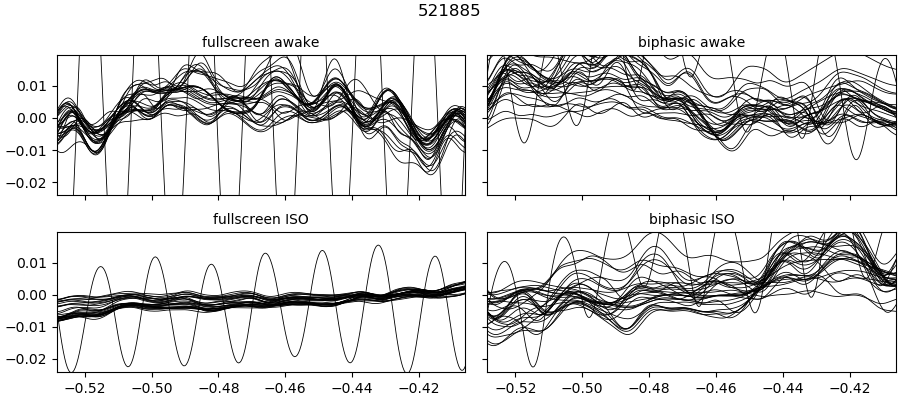

<IPython.core.display.Javascript object>


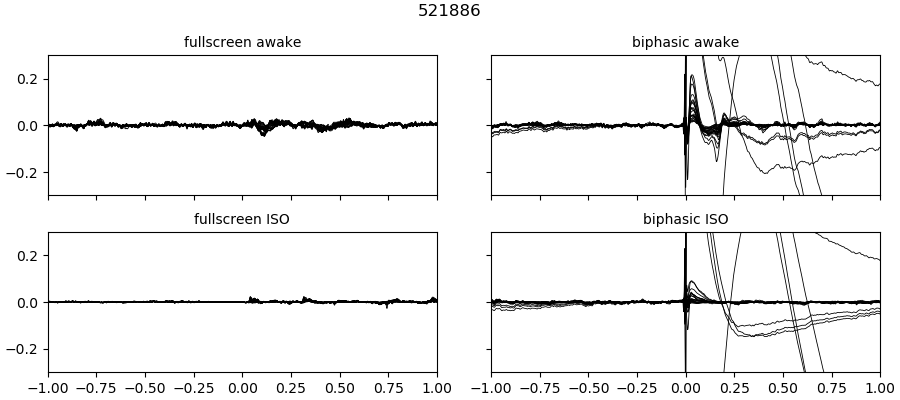

<IPython.core.display.Javascript object>


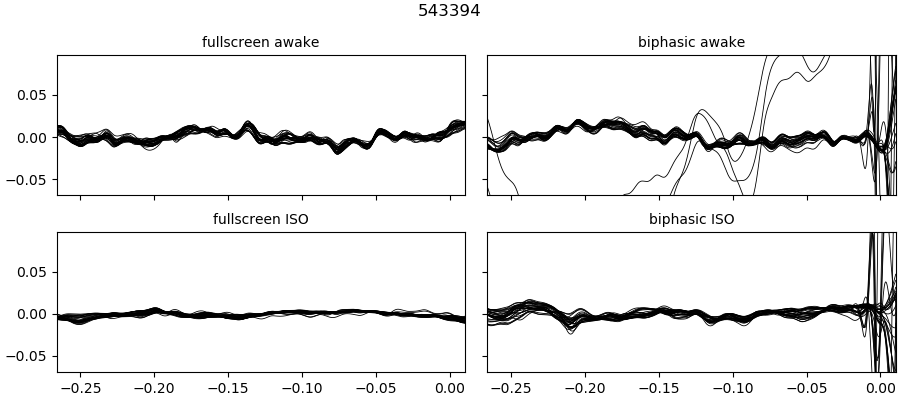

<IPython.core.display.Javascript object>


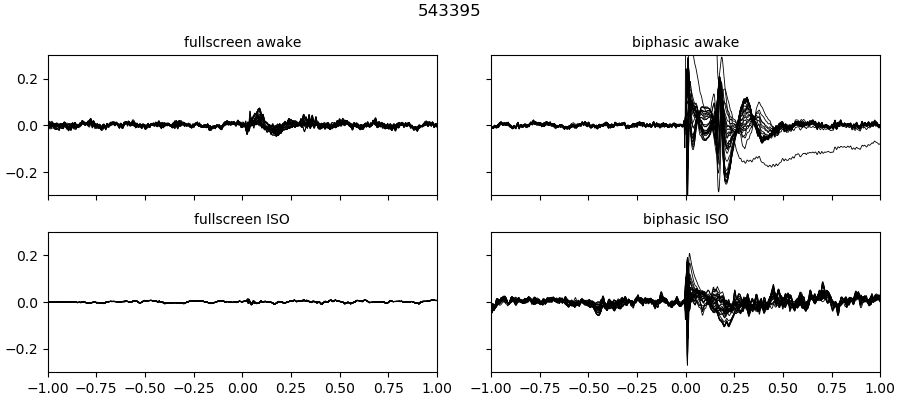

<IPython.core.display.Javascript object>


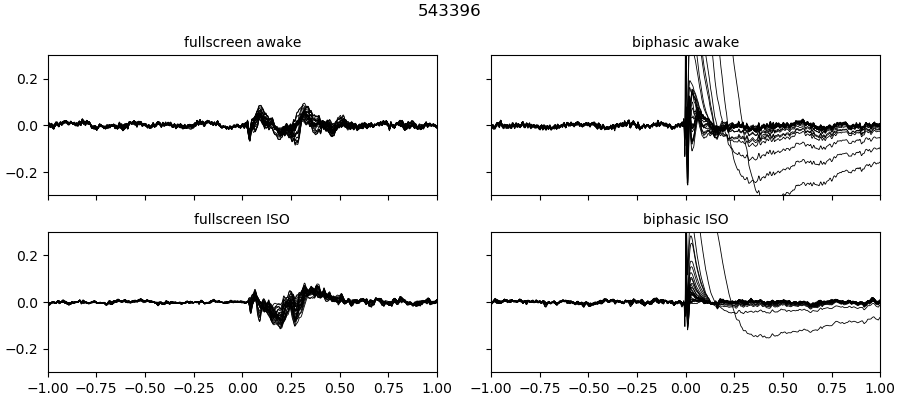

<IPython.core.display.Javascript object>


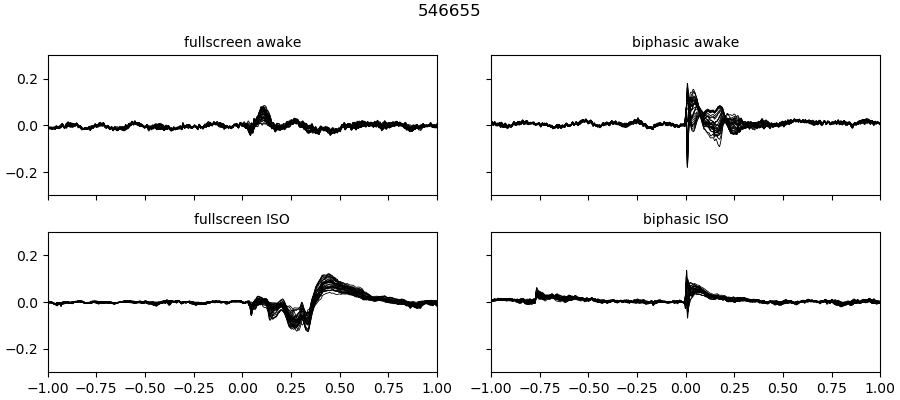

<IPython.core.display.Javascript object>


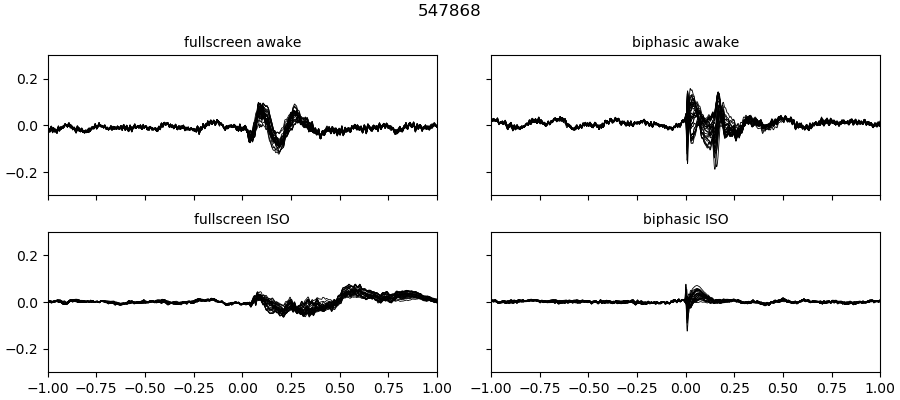

In [15]:
ylimit = 0.3

for mousei, expdict in sub_avg_traces_filter.items():
    
    fig, axs = plt.subplots(2, 2, figsize=(9,4), sharex=True, sharey=True, constrained_layout=True)
    
    ## fullscreen ##
    for i, sweepi in enumerate(state_sweeps[mousei]['fullscreen']):
        axs[i,0].plot(expdict['fullscreen'][sweepi][0], expdict['fullscreen'][sweepi][1]/1000, color='k', linewidth=0.6)
        axs[i,0].set_xlim([-plot_before, plot_after])
        axs[i,0].set_ylim([-ylimit, ylimit])
    axs[0,0].set_title('fullscreen awake')
    axs[1,0].set_title('fullscreen ISO')
    
    ## biphasic ##
    for i, sweepi in enumerate(state_sweeps[mousei]['biphasic']):
        axs[i,1].plot(expdict['biphasic'][sweepi][0], expdict['biphasic'][sweepi][1]/1000, color='k', linewidth=0.6)
        axs[i,1].set_title('biphasic')
    axs[0,1].set_title('biphasic awake')
    axs[1,1].set_title('biphasic ISO')
    
    plt.suptitle(mousei)

## Compare traces and PCI of notch-filtered data

What does notching out 60 Hz do to the traces and the resulting PCIst values?

In [10]:
sub_dirs = {
    '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\recording1',
    '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\recording1',
    '521887': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estimfull_2020-07-30\experiment1\recordingfull',
    '543393': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1',
    '543394': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
    '543395': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\estim1_2020-09-03_13-19-42\experiment1\recording1',
    '543396': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
    '546655': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
}

## Sweep ids for each brain state
brain_states = {
    '521885': {'awake': [0], 'anesthetized': [1], 'recovery': []},
    '521886': {'awake': [0], 'anesthetized': [1], 'recovery': [2]},
    '521887': {'awake': [0, 1], 'anesthetized': [2, 3, 4], 'recovery': [5, 6, 7]},
    '543393': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery': [6, 7, 8]},
    '543394': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery': [6, 7, 8]},
    '543395': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5, 6], 'recovery': [7, 8, 9]},
    '543396': {'awake': [0], 'anesthetized': [1], 'recovery': [2]},
    '546655': {'awake': [0], 'anesthetized': [1], 'recovery': [2, 3]},
}

## Stim amplitudes for the PCI calculation
PCI_stim_amp = {
    '521885': 50,
    '521886': 50,
    '521887': 20,
    '543393': 70,
    '543394': 50,
    '543395': 60,
    '543396': 80,
    '546655': 70,
}

bad_chs = {
    '521885': [6,11,12,13,14],
    '521886': [11,12,13,14,15,16,17], # was [10,11,12,13,14,15,16,17,18]
    '521887': [4,11,12,13,14], # was [4,7,11,12,13,14,18]
    '543393': [11,12,13,14],
    '543394': [11,12,13,14,15,17,18,19,20],
    '543395': [11,12,13], # was [11,13]
    '543396': [4,5,7,8,10,11,12,13], # was [4,5,7,8,10,11,12,13,14]
    '546655': [],
}

In [11]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation


In [12]:
## parameters ##
plot_before = 2.8 # s, look at 100 ms pre-stim
plot_after = 2.8 # s, look at 1000 ms post-stim
sttype = 'biphasic' # can be 'fullscreen', 'auditory', or 'biphasic'

low_pass_cutoff = 100
apply_blsub = False
apply_filter_type = 'BW' # choose 'BW' (Butterworth) or 'FIR'

In [13]:
start = time.time()

sub_stim_amps = {}
sub_num_trials = {}

sub_traces_filter = {}
sub_avg_traces_filter = {}

sub_traces_notch = {}
sub_avg_traces_notch = {}

for mousei, expi in sub_exp.items():
    print(mousei)
    
    # load stim log
    stim_log = pd.read_csv(expi.stimulus_log_file)
    stim_amps = np.sort(stim_log[stim_log['stim_type']==sttype].parameter.unique())
    sub_stim_amps[mousei] = stim_amps
    
    # load data
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(datai.shape[1])
    
    # get evoked traces
    sub_num_trials[mousei] = {}
    
    sub_traces_filter[mousei] = {}
    sub_avg_traces_filter[mousei] = {}
    
    sub_traces_notch[mousei] = {}
    sub_avg_traces_notch[mousei] = {}
    
    for statei, sweeps in brain_states[mousei].items():
        if sweeps:
            sub_num_trials[mousei][statei] = {}
            
            sub_traces_filter[mousei][statei] = {}
            sub_avg_traces_filter[mousei][statei] = {}
            
            sub_traces_notch[mousei][statei] = {}
            sub_avg_traces_notch[mousei][statei] = {}
            
            for ampi in stim_amps:
#                 sub_traces[mousei][statei][str(ampi)] = [] # or is it {}??
#                 sub_avg_traces[mousei][statei][str(ampi)] = []
                
#                 sub_traces_filter[mousei][statei][str(ampi)] = []
#                 sub_avg_traces_filter[mousei][statei][str(ampi)] = []
                
                traces = []
                filtered_traces = []
                notch_traces = []
                for sweepi in sweeps:
                    events = get_stim_events(stim_log, sttype, ampi, sweepi)
                    if len(events) == 0:
                        print('%s, sweep %d, %s uA: no good trials' % (statei, sweepi, str(ampi)))
                        continue
                    event_traces, event_ts = get_evoked_traces(
                        datai,
                        tsi,
                        events,
                        plot_before,
                        plot_after,
                        expi.ephys_params['EEG']['sample_rate']
                    )
                    traces.append(event_traces)
                    
                    # apply lowpass filter
                    if apply_filter_type == 'FIR':
                        filtb = lowpass_filt_design(
                            len(event_ts),
                            expi.ephys_params['EEG']['sample_rate'],
                            cutoff_freq=low_pass_cutoff, # original = 100
                            trans_width=0.2, # original = 0.2
                            order_multiple=11, # original = 11
                            plot_kern=False
                        )
                        filta = 1
                    elif apply_filter_type == 'BW':
                        filtb, filta = signal.butter(
                            3,
                            low_pass_cutoff/(expi.ephys_params['EEG']['sample_rate']/2),
                            btype='low'
                        )
                        
                    # apply filter
                    if apply_blsub:
                        blinds = np.squeeze(np.argwhere((event_ts > -0.2) & (event_ts < -0.005)))
                        LPfilt_traces = signal.filtfilt(filtb, filta, event_traces - np.mean(event_traces[blinds,:,:], axis=0), axis=0)
                        filtered_traces.append(LPfilt_traces)
                    else:
                        LPfilt_traces = signal.filtfilt(filtb, filta, event_traces, axis=0)
                        filtered_traces.append(LPfilt_traces)
                        
                    notch_traces.append(apply_notch_60Hz(LPfilt_traces, expi.ephys_params['EEG']['sample_rate']))
                
                sub_traces_filter[mousei][statei][str(ampi)] = [event_ts, np.concatenate(filtered_traces, axis=2)]
                sub_avg_traces_filter[mousei][statei][str(ampi)] = [event_ts, np.mean(np.concatenate(filtered_traces, axis=2), axis=2)]
                sub_num_trials[mousei][statei][str(ampi)] = np.shape(sub_traces_filter[mousei][statei][str(ampi)][1])[2]
                
                sub_traces_notch[mousei][statei][str(ampi)] = [event_ts, np.concatenate(notch_traces, axis=2)]
                sub_avg_traces_notch[mousei][statei][str(ampi)] = [event_ts, np.mean(np.concatenate(notch_traces, axis=2), axis=2)]
            
    del datai
    del tsi
    del stim_log

end = time.time()
print('Time to analyze: {:.2f} min'.format((end - start) / 60))

521885
521886
521887
543393
543394
543395
anesthetized, sweep 4, 60 uA: no good trials
recovery, sweep 8, 60 uA: no good trials
543396
546655
Time to analyze: 196.31 min


Calculate PCIst

In [14]:
states = ['awake', 'anesthetized']

PCI_params = {
    'baseline_window':(-.5, -.001), # ms before stim for baseline
    'response_window':(.001, .5), # ms after stim for response
    'k':1.2,
    'min_snr':1.1,
    'max_var':99,
    'embed':False,
    'n_steps':100,
}

full_PCI_output = {}
notchfull_PCI_output = {}
for subject in sub_traces_filter.keys():
    print(subject)
    start = time.time()
    
    PCIamp = str(PCI_stim_amp[subject])
    good_chs = [x for x in eegchs if x not in bad_chs[subject]]
    NUM_TRIALS = min([sub_num_trials[subject][x][PCIamp] for x in states])
    print('Trials: {:d}'.format(NUM_TRIALS))
    
    full_PCI_output[subject] = {}
    notchfull_PCI_output[subject] = {}
    for statei in states:
        ## Subselect trials and take avg ##
        if statei == 'recovery':
            avg_traces = np.mean(sub_traces_filter[subject][statei][PCIamp][1][:, :, -NUM_TRIALS:], axis=2)
            notch_avg_traces = np.mean(sub_traces_notch[subject][statei][PCIamp][1][:, :, -NUM_TRIALS:], axis=2)
        else:
            avg_traces = np.mean(sub_traces_filter[subject][statei][PCIamp][1][:, :, :NUM_TRIALS], axis=2)
            notch_avg_traces = np.mean(sub_traces_notch[subject][statei][PCIamp][1][:, :, :NUM_TRIALS], axis=2)
        
        ## Calculate PCIst with full return ##
        full_PCI_output[subject][statei] = calc_PCIst(
            avg_traces[:, good_chs].T,
            sub_traces_filter[subject][statei][PCIamp][0],
            full_return=True,
            **PCI_params
        )
        notchfull_PCI_output[subject][statei] = calc_PCIst(
            notch_avg_traces[:, good_chs].T,
            sub_traces_notch[subject][statei][PCIamp][0],
            full_return=True,
            **PCI_params
        )

        print('{:s} PCI = {:.3f}'.format(statei, full_PCI_output[subject][statei]['PCI']))
        print('{:s} notch PCI = {:.3f}'.format(statei, notchfull_PCI_output[subject][statei]['PCI']))
    end = time.time()
    print('Time: {:.2f} s'.format(end-start))
    print('')

521885
Trials: 55
awake PCI = 37.573
awake notch PCI = 37.195
anesthetized PCI = 20.290
anesthetized notch PCI = 19.928
Time: 81.58 s

521886
Trials: 84
awake PCI = 28.619
awake notch PCI = 28.252
anesthetized PCI = 6.387
anesthetized notch PCI = 6.291
Time: 51.57 s

521887
Trials: 156
awake PCI = 39.144
awake notch PCI = 41.207
anesthetized PCI = 9.460
anesthetized notch PCI = 9.571
Time: 71.01 s

543393
Trials: 254
awake PCI = 49.371
awake notch PCI = 49.924
anesthetized PCI = 21.974
anesthetized notch PCI = 21.832
Time: 101.66 s

543394
Trials: 281
awake PCI = 24.052
awake notch PCI = 25.932
anesthetized PCI = 10.993
anesthetized notch PCI = 11.782
Time: 71.00 s

543395
Trials: 162
awake PCI = 51.443
awake notch PCI = 52.739
anesthetized PCI = 64.062
anesthetized notch PCI = 65.365
Time: 100.43 s

543396
Trials: 100
awake PCI = 49.658
awake notch PCI = 49.960
anesthetized PCI = 15.871
anesthetized notch PCI = 13.659
Time: 85.62 s

546655
Trials: 94
awake PCI = 36.397
awake notch PCI

In [15]:
sub_PCI_values = {}
for mousei in full_PCI_output.keys():
    sub_PCI_values[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        sub_PCI_values[mousei][statei] = full_PCI_output[mousei][statei]['PCI']
        sub_PCI_values[mousei][statei+'_notch'] = notchfull_PCI_output[mousei][statei]['PCI']
pci_df = pd.DataFrame(sub_PCI_values)
PCIvalues = pci_df.to_numpy()
pci_df.head()

,521885,521886,521887,543393,543394,543395,543396,546655
awake,37.572756,28.618981,39.144155,49.370988,24.052227,51.442784,49.658125,36.396937
awake_notch,37.194977,28.251606,41.207088,49.923905,25.932165,52.738970,49.960202,36.509902
anesthetized,20.290039,6.387188,9.459976,21.973680,10.993273,64.061861,15.870519,12.302460
anesthetized_notch,19.927672,6.290839,9.571473,21.831720,11.782140,65.364658,13.659382,12.635333


<IPython.core.display.Javascript object>


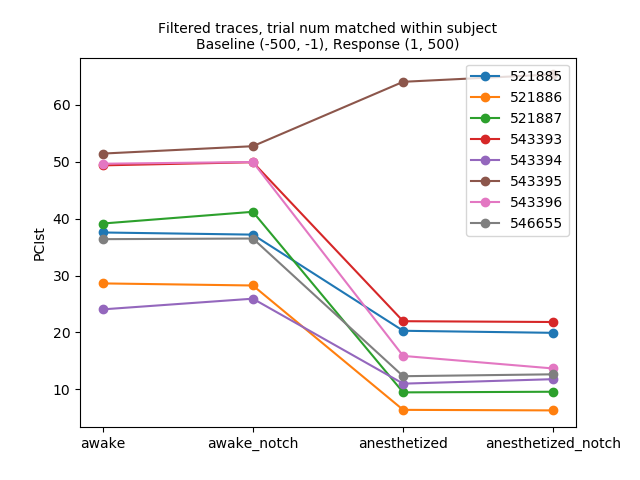

Text(0.5, 1.0, 'Filtered traces, trial num matched within subject\nBaseline (-500, -1), Response (1, 500)')

In [40]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(0, PCIvalues.shape[0]),
    PCIvalues,
    marker='o',
)
ax.set_xticks(np.arange(0, PCIvalues.shape[0]))
ax.set_xticklabels(list(pci_df.index.values))
ax.set_ylabel('PCIst')
ax.legend(list(pci_df.columns))
ax.set_title(
    'Filtered traces, trial num matched within subject\nBaseline ({:.0f}, {:.0f}), Response ({:.0f}, {:.0f})'.format(
        PCI_params['baseline_window'][0]*1000,
        PCI_params['baseline_window'][1]*1000,
        PCI_params['response_window'][0]*1000,
        PCI_params['response_window'][1]*1000,
    ))

<IPython.core.display.Javascript object>


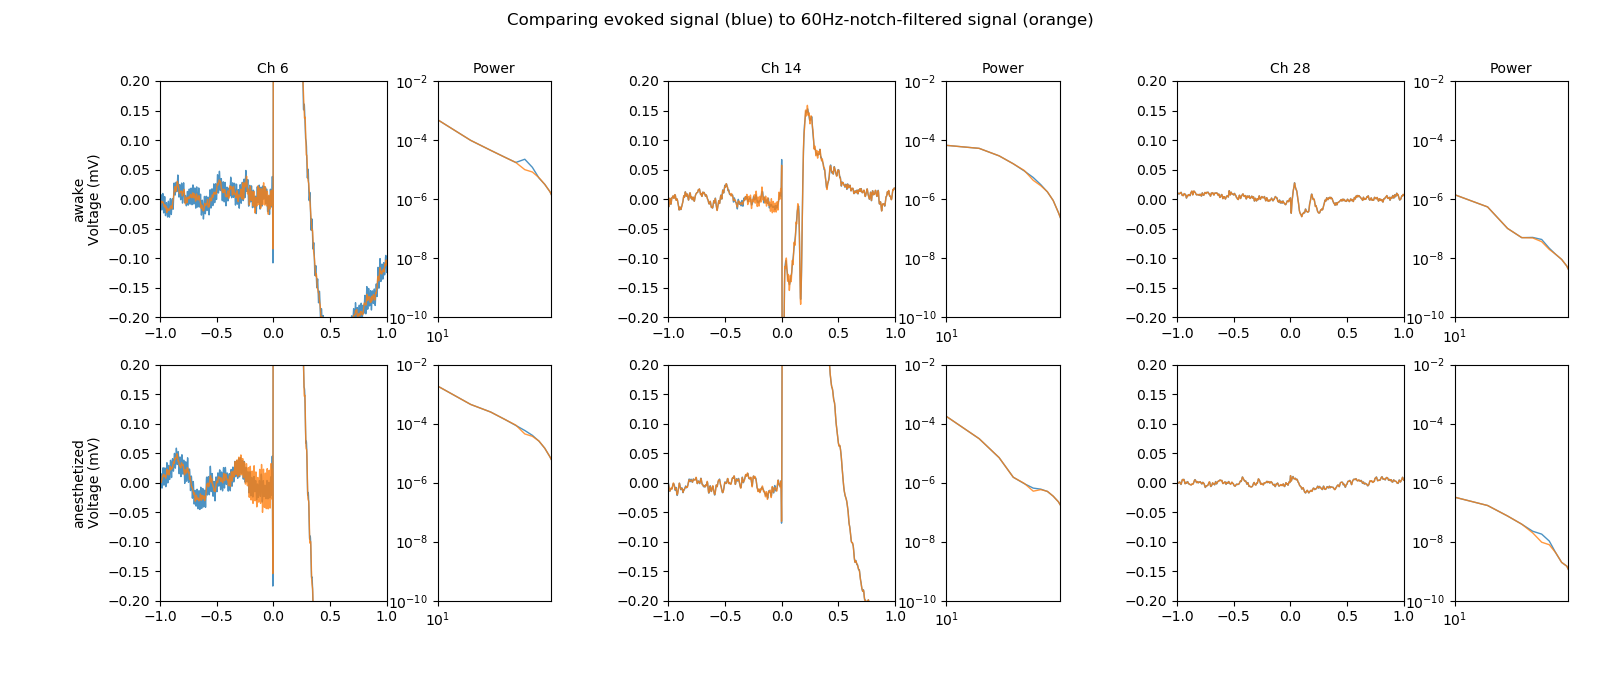

<IPython.core.display.Javascript object>


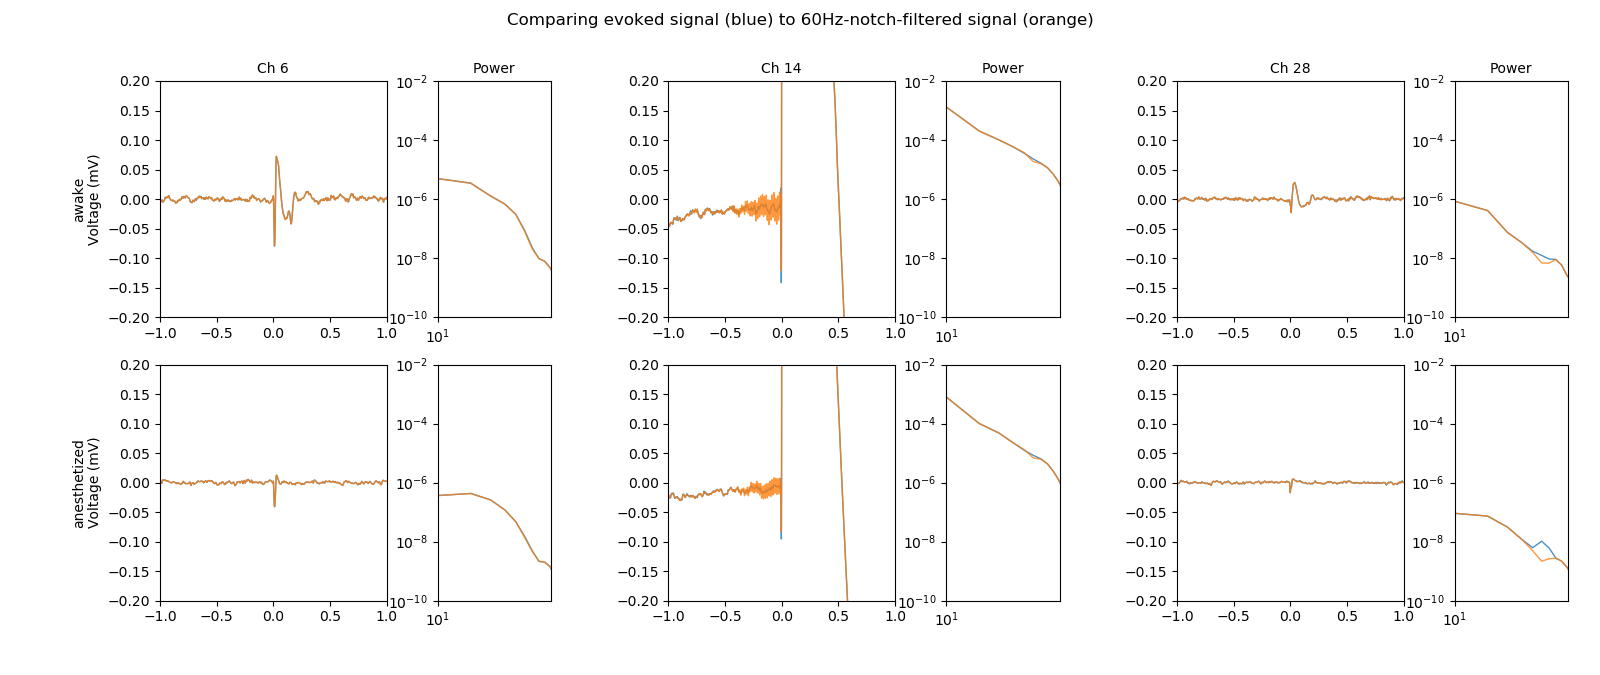

<IPython.core.display.Javascript object>


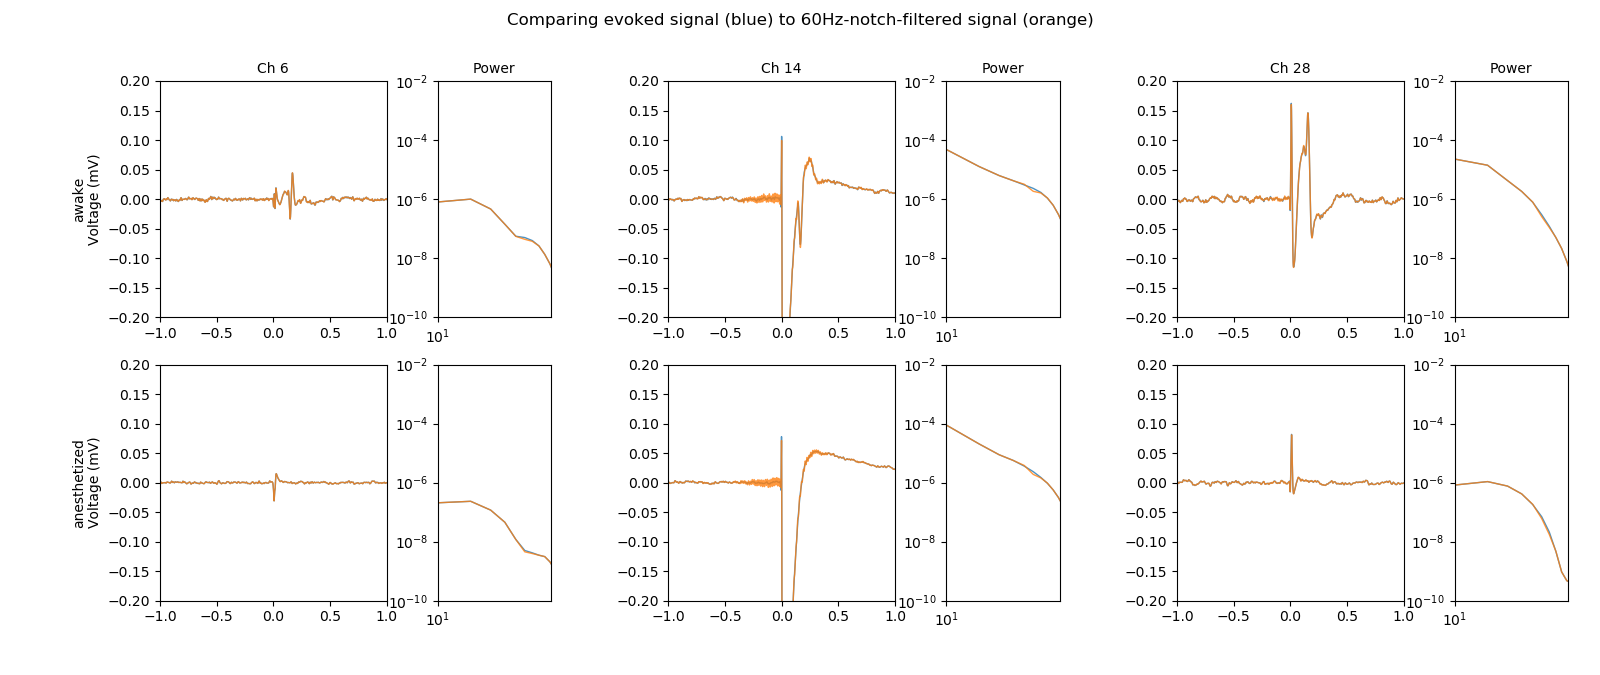

<IPython.core.display.Javascript object>


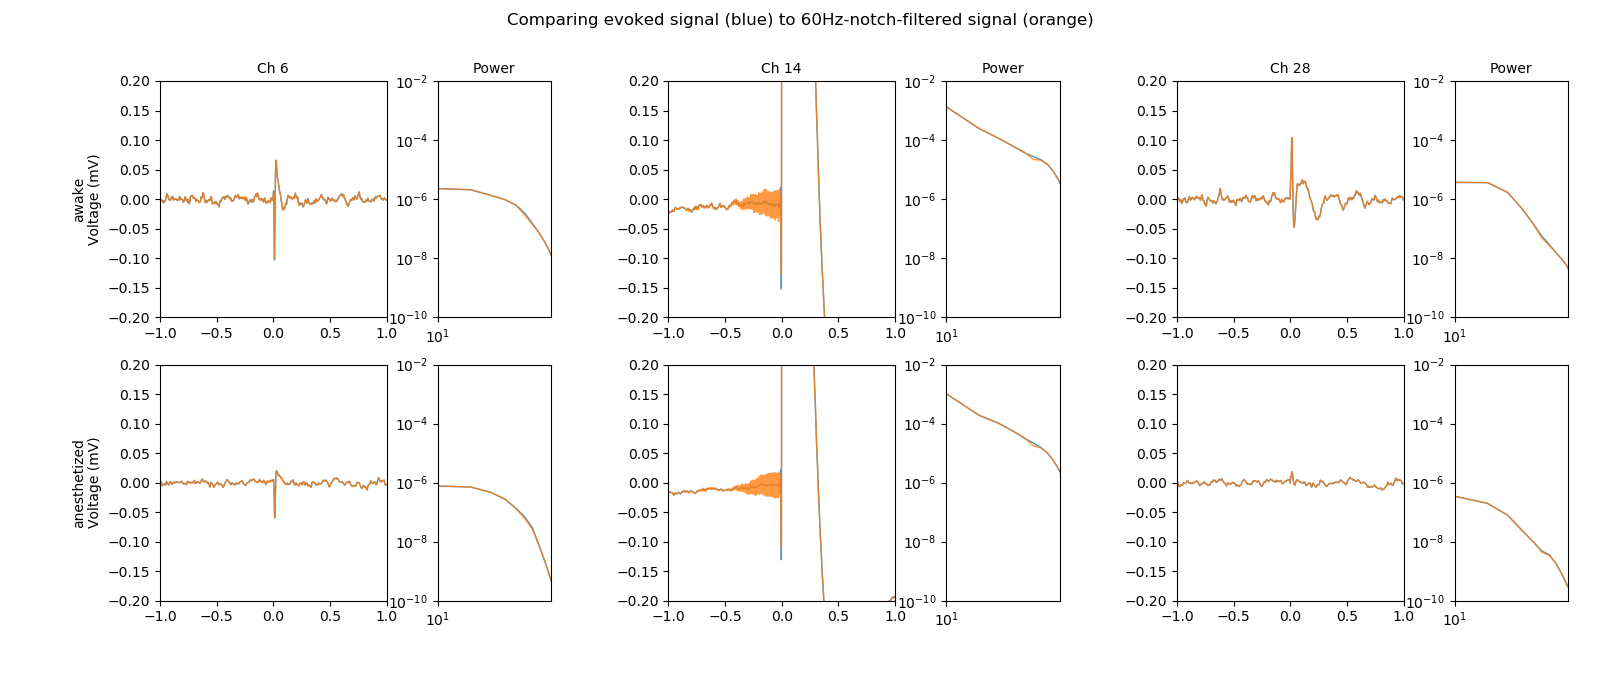

<IPython.core.display.Javascript object>


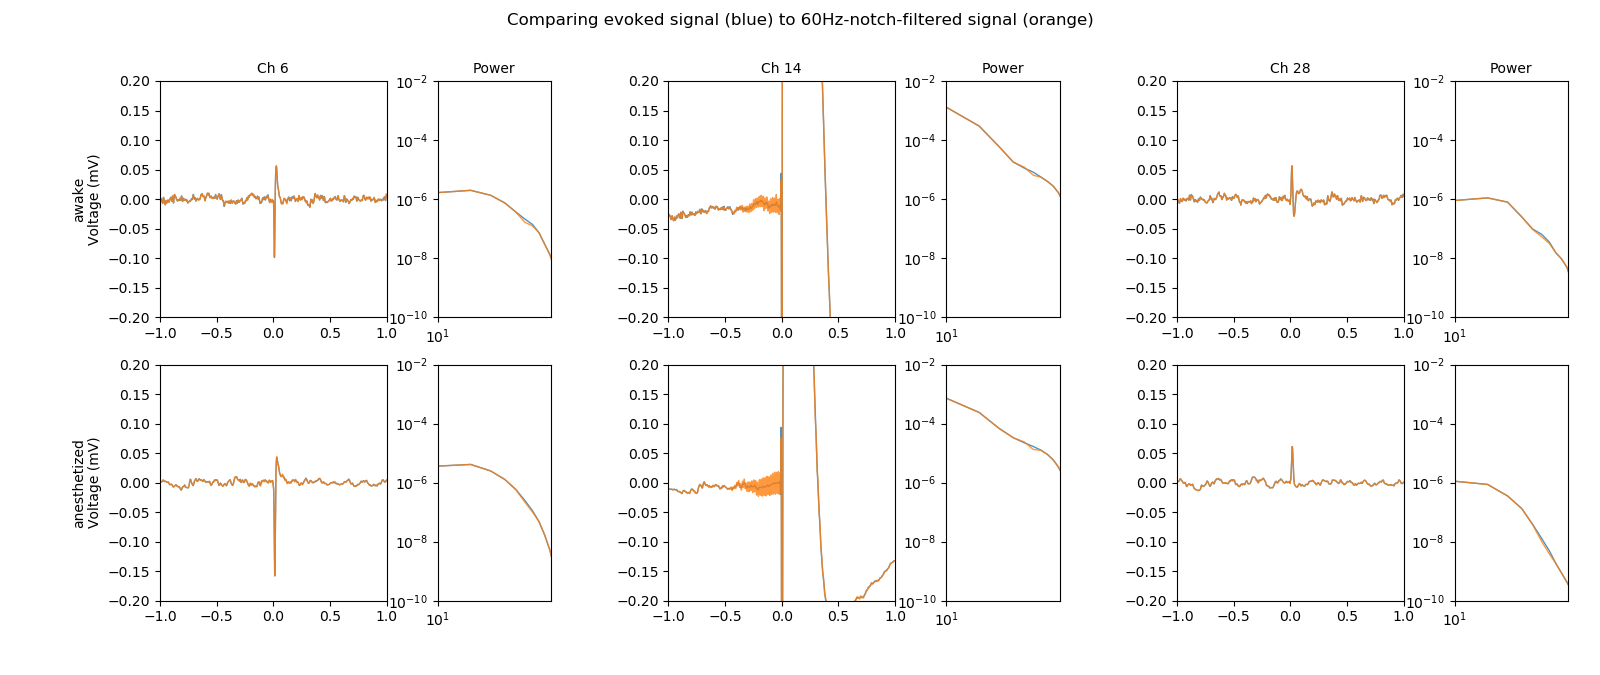

<IPython.core.display.Javascript object>


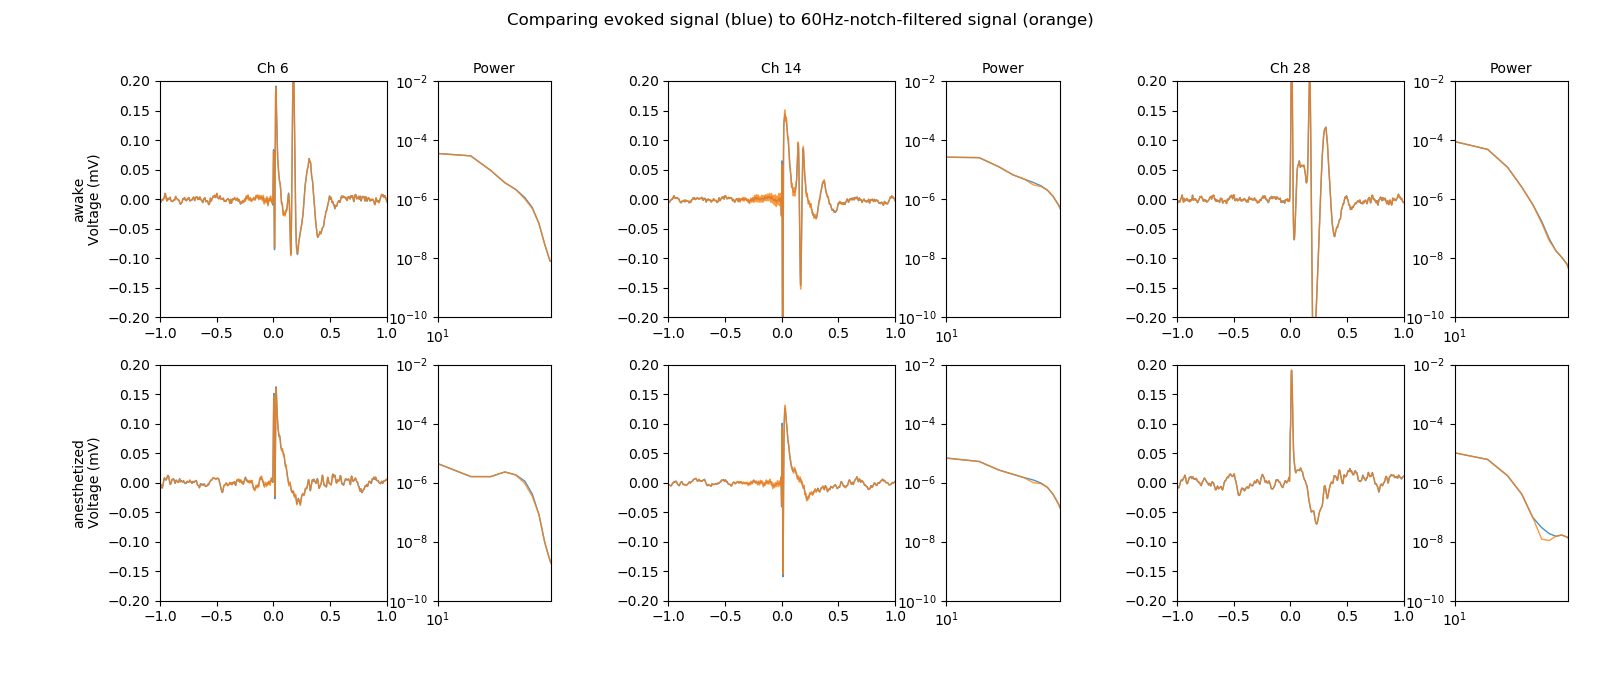

<IPython.core.display.Javascript object>


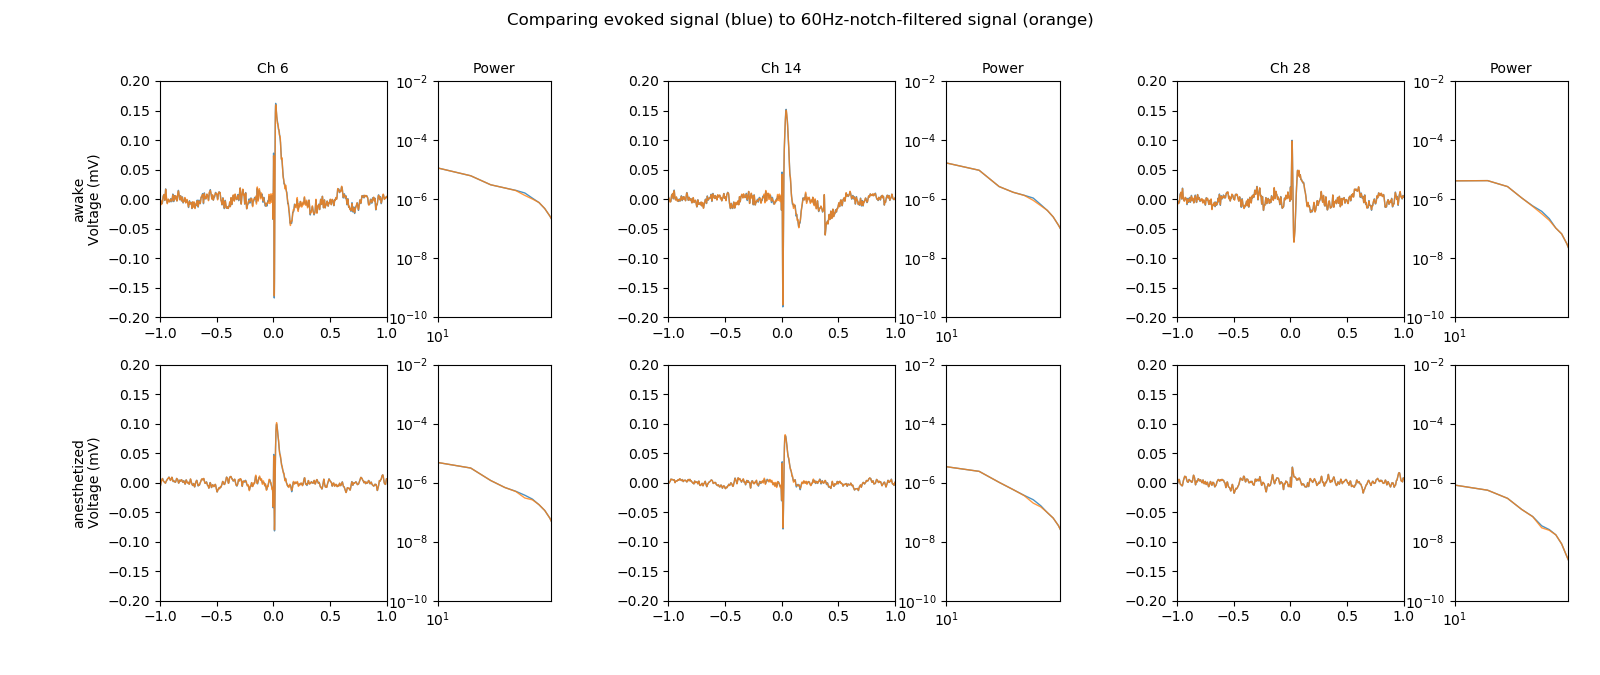

<IPython.core.display.Javascript object>


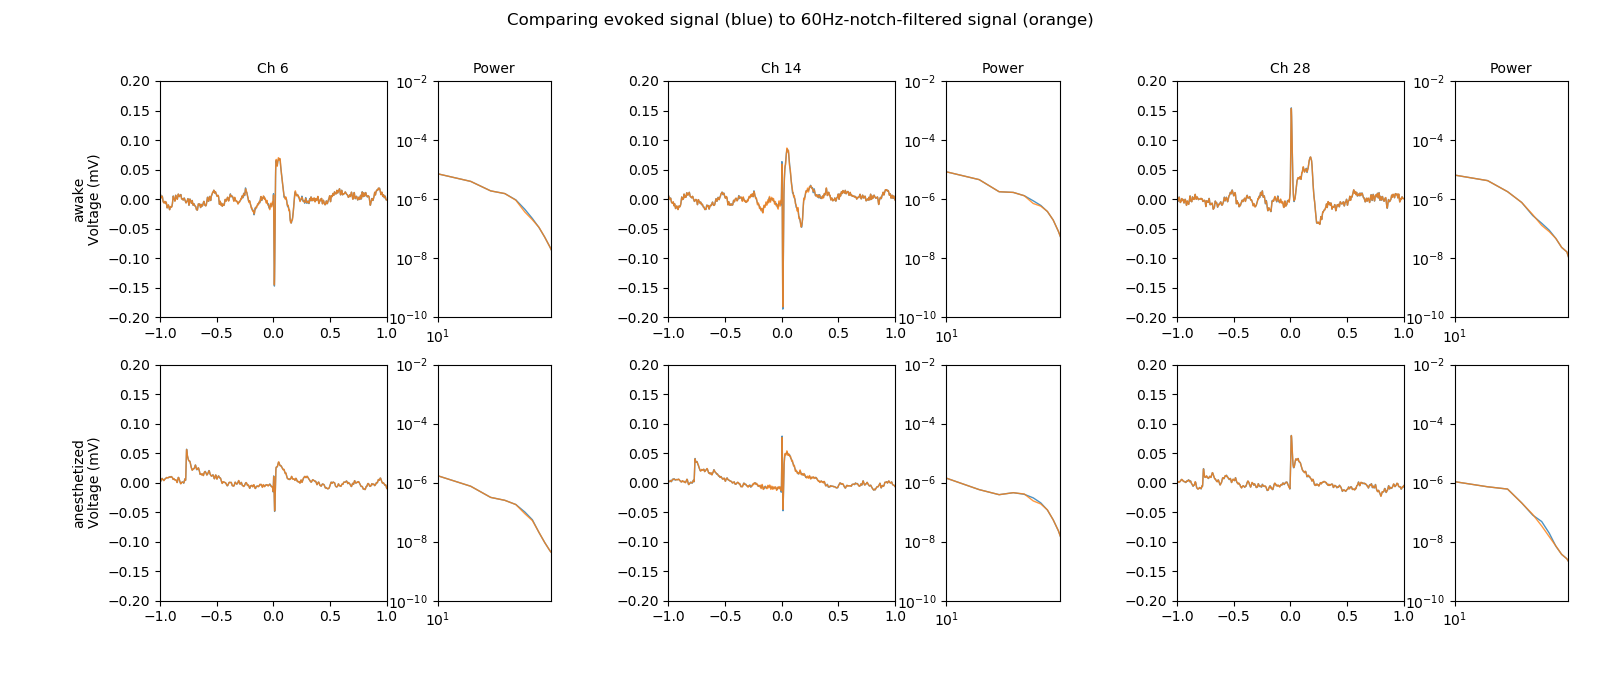

In [62]:
## Plot filtered traces and notch traces with spectra ##
prex = 1.
postx = 1.
y_limit = .2
plot_states = ['awake', 'anesthetized']
plot_chs = [6, 14, 28]
plot_traces = [sub_avg_traces_filter, sub_avg_traces_notch]

for mousei in sub_exp.keys():
    plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+mousei)
    if not os.path.exists(plotsavedir):
        os.mkdir(plotsavedir)

    fig = plt.figure(figsize=(16,9*0.75)) #, constrained_layout=True)
    gs = fig.add_gridspec(ncols=len(plot_chs), nrows=len(plot_states), left=0.1, right=0.98, wspace=0.3)

    for row, statei in enumerate(plot_states):
        for col, chi in enumerate(plot_chs):
            gsi = gs[row, col].subgridspec(ncols=2, nrows=1, width_ratios=[2,1], wspace=0.3)
            axeeg = fig.add_subplot(gsi[0])
            axspec = fig.add_subplot(gsi[1])
            for data in plot_traces:
                timeaxis = data[mousei][statei][str(PCI_stim_amp[mousei])][0]
                pinds = np.squeeze(np.argwhere((timeaxis >= -prex) & (timeaxis <= postx)))
                ptraces = data[mousei][statei][str(PCI_stim_amp[mousei])][1][pinds,chi]/1000
                ## Use Welch's method to get spectra ##
                frex, Pxx = signal.welch(ptraces, sub_exp[mousei].ephys_params['EEG']['sample_rate'], nperseg=256, axis=0)
                frinds = frex < 200
                ## Plot ##
                axeeg.plot(timeaxis[pinds], ptraces, linewidth=1, alpha=0.8)
                axspec.loglog(frex[frinds], Pxx[frinds], linewidth=1, alpha=0.8)
            axeeg.set_xlim([-prex, postx])
            axeeg.set_ylim([-y_limit, y_limit])
            axspec.set_xlim([1e1, 1e2])
            axspec.set_ylim([1e-10, 1e-2])
            if row == 0:
                axeeg.set_title('Ch {:d}'.format(chi))
                axspec.set_title('Power')
            if col == 0:
                axeeg.set_ylabel('{:s}\nVoltage (mV)'.format(statei))
    #             axspec.set_ylabel('Power (mV^2/Hz)')

    # plt.suptitle('Mouse {:s}'.format(mousei))
    plt.suptitle('Comparing evoked signal (blue) to 60Hz-notch-filtered signal (orange)')
    
    ## Save butterfly figure ##
#     fig.savefig(os.path.join(plotsavedir, 'notch filtered signal comparison.png'), transparent=True)

<IPython.core.display.Javascript object>


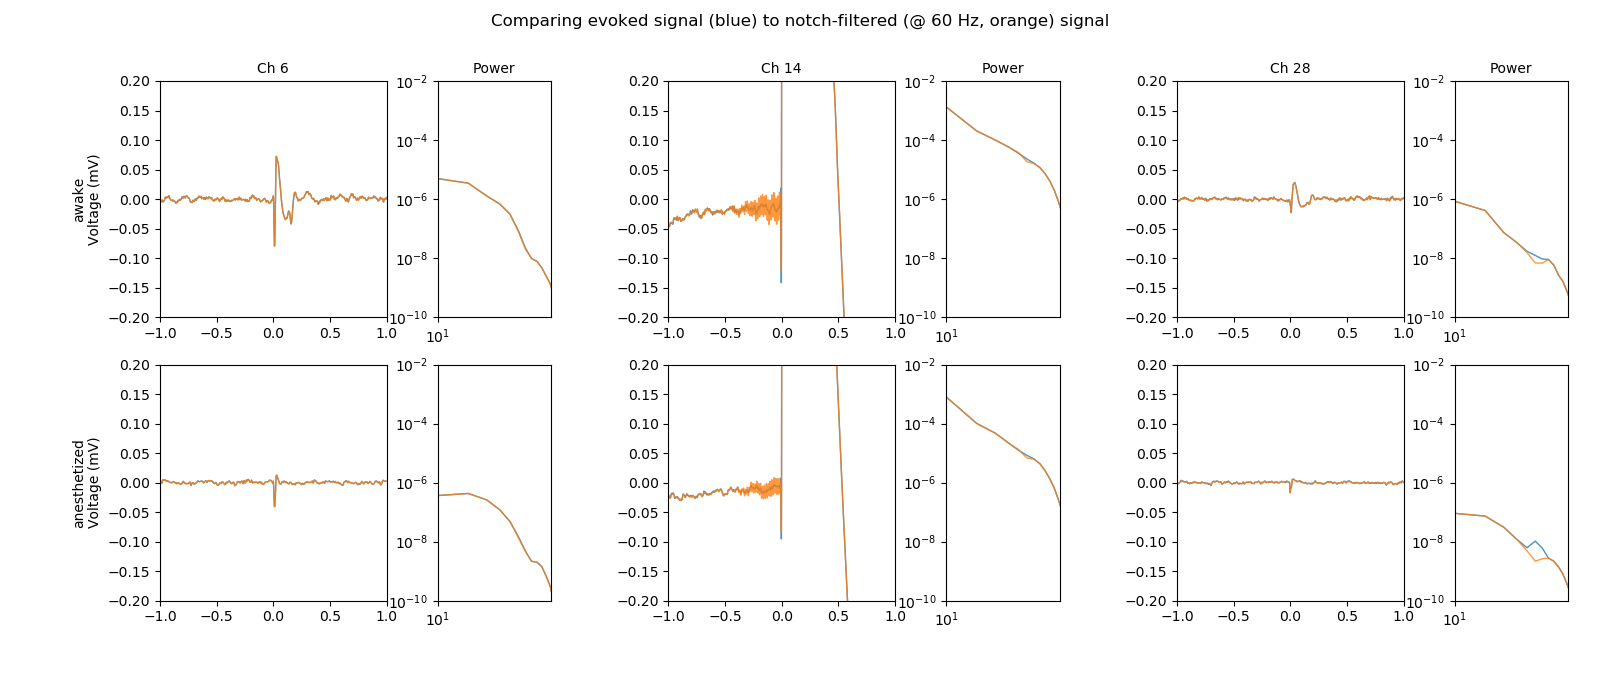

Text(0.5, 0.98, 'Comparing evoked signal (blue) to notch-filtered (@ 60 Hz, orange) signal')

In [60]:
## Plotting examples from just one mouse ##
prex = 1.
postx = 1.
y_limit = .2
plot_states = ['awake', 'anesthetized']
plot_chs = [6, 14, 28]
plot_traces = [sub_avg_traces_filter, sub_avg_traces_notch]

mousei = '521886'

fig = plt.figure(figsize=(16,9*0.75)) #, constrained_layout=True)
gs = fig.add_gridspec(ncols=len(plot_chs), nrows=len(plot_states), left=0.1, right=0.98, wspace=0.3)

for row, statei in enumerate(plot_states):
    for col, chi in enumerate(plot_chs):
        gsi = gs[row, col].subgridspec(ncols=2, nrows=1, width_ratios=[2,1], wspace=0.3)
        axeeg = fig.add_subplot(gsi[0])
        axspec = fig.add_subplot(gsi[1])
        for data in plot_traces:
            timeaxis = data[mousei][statei][str(PCI_stim_amp[mousei])][0]
            pinds = np.squeeze(np.argwhere((timeaxis >= -prex) & (timeaxis <= postx)))
            ptraces = data[mousei][statei][str(PCI_stim_amp[mousei])][1][pinds,chi]/1000
            ## Use Welch's method to get spectra ##
            frex, Pxx = signal.welch(ptraces, sub_exp[mousei].ephys_params['EEG']['sample_rate'], nperseg=256, axis=0)
            frinds = frex < 200
            ## Plot ##
            axeeg.plot(timeaxis[pinds], ptraces, linewidth=1, alpha=0.8)
            axspec.loglog(frex[frinds], Pxx[frinds], linewidth=1, alpha=0.8)
        axeeg.set_xlim([-prex, postx])
        axeeg.set_ylim([-y_limit, y_limit])
        axspec.set_xlim([1e1, 1e2])
        axspec.set_ylim([1e-10, 1e-2])
        if row == 0:
            axeeg.set_title('Ch {:d}'.format(chi))
            axspec.set_title('Power')
        if col == 0:
            axeeg.set_ylabel('{:s}\nVoltage (mV)'.format(statei))
#             axspec.set_ylabel('Power (mV^2/Hz)')
        
# plt.suptitle('Mouse {:s}'.format(mousei))
plt.suptitle('Comparing evoked signal (blue) to 60Hz-notch-filtered signal (orange)')

## Make a 60 Hz sine and average across random "events"

Averaging across random timepoints in a purely 60 Hz sine wave will still result in a 60 Hz sine wave, even though the signal is not necessarily in phase. But the more "trials" you average over the smaller the amplitude of the oscillation in the resulting average trace.

<IPython.core.display.Javascript object>


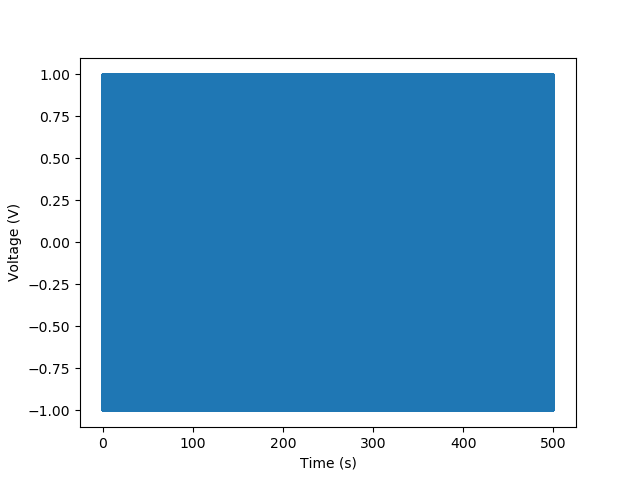

Text(0, 0.5, 'Voltage (V)')

In [23]:
signal_duration = 500. # duration in s
sample_rate = 2500
freq = 60

x = np.arange(signal_duration * sample_rate)
y = np.sin(2 * np.pi * freq * x / sample_rate)
timex = x / sample_rate

fig, ax = plt.subplots()
ax.plot(timex, y)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

In [44]:
n_trials = 50
ISI_range = [3.5, 4.5]
fake_events = np.cumsum(np.random.uniform(ISI_range[0], ISI_range[1], n_trials))
# print(fake_events)

In [37]:
print(np.diff(fake_events))

[3.68385255 4.40262868 3.56192779 4.26802861 3.76091033 4.37151851
 3.52696998 3.71174027 4.4031339  4.00201654 4.47544071 4.16432074
 3.7959327  4.16645814 4.21073383 3.93317782 3.89918073 3.86755462
 3.85955456 4.1080153  3.9507302  4.00815791 3.58744121 4.36390188
 4.44219538 4.25482307 4.21955577 4.35908783 4.13028799 3.84471051
 3.7340587  4.36452313 3.78659599 3.86914736 4.10837992 4.05579014
 4.18403046 3.54146949 3.82583439 4.28207862 3.94485249 4.39277583
 3.91226116 4.10127132 4.37020951 3.90466884 3.75750837 4.44674049
 3.9503277 ]


In [45]:
plot_before = 1.0
plot_after = 1.0

pre_inds = int(plot_before * sample_rate)
post_inds = int(plot_after * sample_rate)
fake_timex = (np.arange(-pre_inds, post_inds) / sample_rate)
fake_traces = np.zeros((len(fake_timex), len(fake_events)))
for j, jtime in enumerate(fake_events):
    zeroind = find_nearest_ind(timex, jtime)
    data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
    fake_traces[:,j] = y[data_inds]
print(fake_traces.shape)

(5000, 50)


<IPython.core.display.Javascript object>


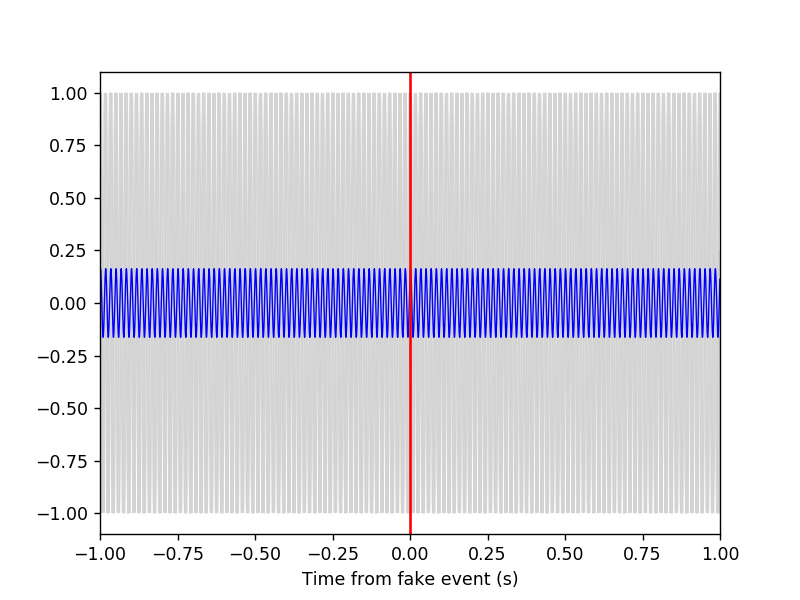

Text(0.5, 0, 'Time from fake event (s)')

In [46]:
fig, ax = plt.subplots()

ax.plot(fake_timex, fake_traces[:,:5], color='lightgray', linewidth=0.6)
ax.plot(fake_timex, np.mean(fake_traces, axis=1), color='b', linewidth=0.8)
ax.axvline(0, color='r')

ax.set_xlim([-plot_before, plot_after])
ax.set_xlabel('Time from fake event (s)')

## Power in 60 Hz and gamma band over time

In [9]:
rec_folder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [10]:
eegdata, eegts = exp.load_eegdata()

In [11]:
iso_max_times, iso_maint_times = exp.load_iso_times()
print(iso_max_times)
print(iso_maint_times)

(927.67, 1305.62)
(1310.03, 2262.72)


Need to bandpass filter the data prior to doing Hilbert transform.

In [12]:
names = ['low gamma', '60Hz', 'high gamma']
freq_bands = [[30,50], [59,61], [70,100]]
tr_widths = [0.2, 0.1, 0.2]
FIRorders = [11, 15, 11]

ds_factor = exp.ephys_params['EEG']['sample_rate'] / 0.2

ds_Hilbert_amps = {}
for band, freq_band, tw, FIRord in zip(names, freq_bands, tr_widths, FIRorders):
    print(band)
    start = time.time()
    # design filter kernel #
    filtkern = bandpass_filt_design(
        len(eegts),
        exp.ephys_params['EEG']['sample_rate'],
        freq_limits=freq_band,
        trans_width=tw,
        order_multiple=FIRord,
        plot_kern=False
    )
    # filter & Hilbert signal #
    analytical = signal.hilbert(signal.filtfilt(filtkern, 1, eegdata, axis=0), axis=0)
    # downsample and store amplitude #
    ds_Hilbert_amps[band] = signal.resample(np.abs(analytical), int(analytical.shape[0] / ds_factor), eegts, axis=0)
    del filtkern
    del analytical
    end = time.time()
    print('Time to calculate: {:.2f} s'.format(end-start))

low gamma
Time to calculate: 190.53 s
60Hz
Time to calculate: 207.52 s
high gamma
Time to calculate: 200.30 s


Plot amplitude of bands together

<IPython.core.display.Javascript object>


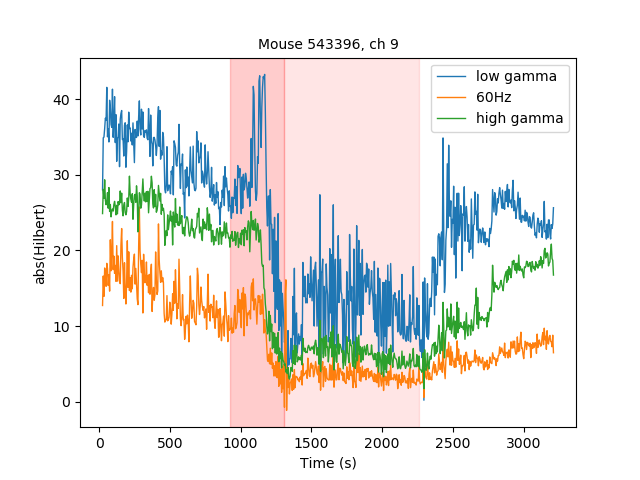

In [19]:
chi = 9

fig, ax = plt.subplots()
for band in names:
    ax.plot(ds_Hilbert_amps[band][1], ds_Hilbert_amps[band][0][:, chi], linewidth=1.0, label=band)
ax.axvspan(iso_max_times[0], iso_max_times[1], color='r', alpha=0.2)
ax.axvspan(iso_maint_times[0], iso_maint_times[1], color='r', alpha=0.1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('abs(Hilbert)')
# ax.set_ylim([0, 400])
ax.set_title('Mouse {:s}, ch {:d}'.format(exp.mouse, chi))
ax.legend()

Individual bands

<IPython.core.display.Javascript object>


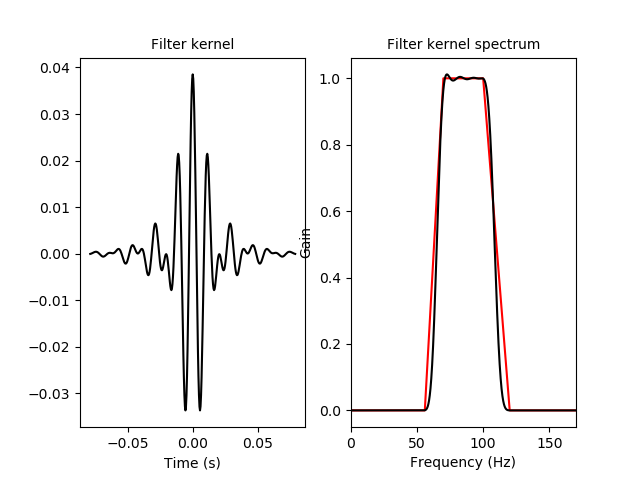

In [61]:
filtb = bandpass_filt_design(
    len(eegts),
    exp.ephys_params['EEG']['sample_rate'],
    freq_limits=[70,100], # original = [30,50]
    trans_width=0.2, # original = 0.2
    order_multiple=11, # original = 4 in bandpass, used 11 in lowpass
    plot_kern=True
)

In [34]:
filteeg = signal.filtfilt(filtb, 1, eegdata, axis=0)

Apply Hilbert transform

In [35]:
analytical_data = signal.hilbert(filteeg, axis=0)
amplitude = np.abs(analytical_data)
print(amplitude.shape)

(5929984, 30)


In [18]:
print(eegdata.shape)

(5929984, 30)


In [49]:
ds_factor = exp.ephys_params['EEG']['sample_rate'] / 0.2
ds_amplitude, ds_time = signal.resample(amplitude, int(amplitude.shape[0] / ds_factor), eegts, axis=0)

<IPython.core.display.Javascript object>


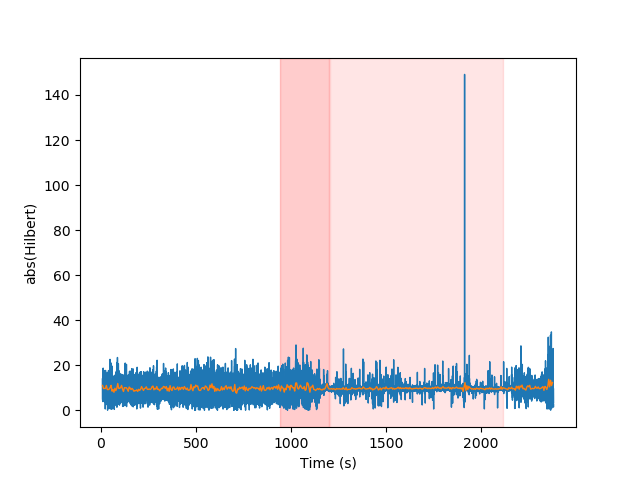

Text(0, 0.5, 'abs(Hilbert)')

In [53]:
chi = 5

fig, ax = plt.subplots()

ax.plot(eegts, amplitude[:, chi], linewidth=1.0)
ax.plot(ds_time, ds_amplitude[:, chi], linewidth=1.0)
ax.axvspan(iso_max_times[0], iso_max_times[1], color='r', alpha=0.2)
ax.axvspan(iso_maint_times[0], iso_maint_times[1], color='r', alpha=0.1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('abs(Hilbert)')

Spectrograms

In [16]:
frex, stime, pwr = signal.spectrogram(eegdata, exp.ephys_params['EEG']['sample_rate'], nperseg=np.power(2,15), axis=0)
print(frex.shape)
print(stime.shape)
print(pwr.shape)

(16385,)
(278,)
(16385, 30, 278)


In [17]:
frinds = frex < 100
pwr_frinds = pwr[frinds,:,:]
print(np.min(pwr_frinds))
print(np.max(pwr_frinds))

9.25980926699356e-09
269260.59723368543


<IPython.core.display.Javascript object>


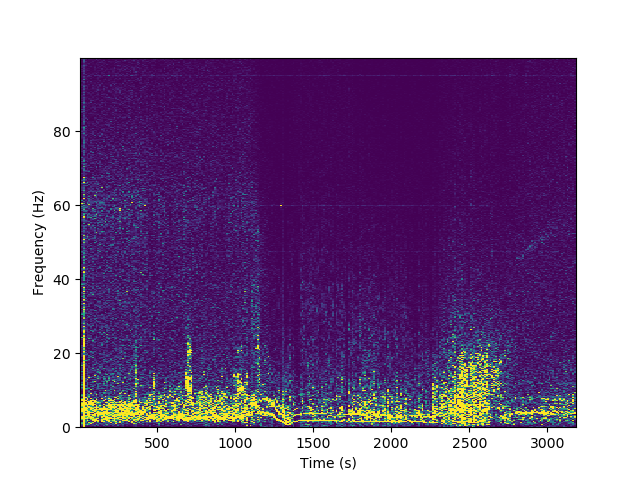

In [23]:
chi = 14

plt.pcolormesh(stime, frex[frinds], pwr_frinds[:,chi,:], vmin=0, vmax=200)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.show()